<a href="https://colab.research.google.com/github/beckyeng226/CapstoneProject/blob/main/Capstone_Project_Live_Birth_Data_Working_File_2_1_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSC 691 Machine Learning Capstone Project:
# Predictive Ability of Paternal Characteristics on Prenatal and Perinatal Outcomes
## Rebecca Eng
## Spring 1 2023

## Goals of the project

Most of the research on prenatal and perinatal outcomes for mothers and infants focuses on maternal characteristics and demographics, and research on the impact of paternal characteristics and demographics is scarce (Mutsaerts et a., 2014).  However, the potential emotional and physical support fathers provide for the mother during the prenatal period may also play a role in outcomes for both the mother and the child.  Therefore, the intent of this project is to take a closer look at what paternal demographic characteristics can predict with regard to characteristics of the pregnancy and delivery and outcomes of the infant at birth.

A study by Mutsaerts et al. (2014) examined paternal and maternal lifestyle characteristics and the effect those had on the mother’s health during pregnancy.  Specifically, the study considered paternal age, height, weight, smoking habits, alcohol consumption, level of physical activity, educational level, number of hours worked per week, and household income as predictors of complications during pregnancy or delivery, such as issues related to hypertension, and gestational diabetes, preterm birth, infants born small for gestational age (Mutsaerts et al., 2014).  Results indicated that paternal factors were correlated with maternal factors and were not associated with the measured pregnancy outcomes after controlling for maternal factors (Mutsaerts et al., 2014).  

These results were not surprising given that the mother’s behaviors and lifestyle choices would be expected to have better predictive ability with these physical outcomes of the mother (hypertension, gestational diabetes, etc.) because they are more directly related to the mother’s physical health.  The proposed project attempts to examine social and environmental factors related to pregnancy and birth outcomes because fathers may have a more significant contribution to outcomes in those areas rather than on the physical health outcomes of the mother.  

Using the 2021 Natality Public Use File from the CDC (https://www.cdc.gov/nchs/data_access/VitalStatsOnline.htm#Births), the proposed project will examine the predictive ability of paternal characteristics to pregnancy outcomes for the mother and infant.  Specifically, machine learning models will be used to measure how the demographic characteristics of the father (race, age, marital status, and education) predict: 

Characteristics of the pregnancy and delivery:
Number of prenatal care visits
WIC
Method of delivery (vaginal or cesarean section)
Trial of labor was attempted (if delivery was via cesarean)

Infant:
Period of gestation
Birth weight
Infant breastfed at discharge

In addition, to determine how valuable the contribution of paternal characteristics is to predicting maternal and infant outcomes, I will also compare the paternal results with the predictive ability of the maternal demographics on the same variables, as well as examine the combination of the maternal and paternal characteristics to see if this improves the predictive ability of the model.  It is hypothesized that paternal demographic characteristics will be predictive of the characteristics of the pregnancy and delivery and infant outcomes at birth and that inclusion of these paternal characteristics will improve the predictive ability of the maternal characteristics only model when both sets of characteristics are combined.
Models of paternal demographic characteristics, maternal demographic characteristics, and the combined parental characteristics will be deployed on a personal website for examination.  The website will also include a resume and a projects page that will link to other completed projects.


In [104]:
#import standard libraries

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, figure

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data Description

The full proposed dataset consists of 3,669,928 records of live births of US residents born in the United States from the 50 states, New York City, and Washington DC during the year 2021.  Data were reported to the Centers for Disease Control and Prevention’s (CDC) National Center for Health Statistics (NCHS) by each state’s and city’s Vital Statistics Cooperative Program and aggregated at a national level.  Data includes all births occurring in the US to both US residents and non-residents, but does not include births to residents living in other countries.

The full dataset includes 225 variables, some of which are re-coded versions of other variables.  For example, mother’s race is reported in 31 potential categories, but then this information is re-coded into a 6 category variable and a 15 category variable.  Also, the data include variables indicating if data for variables was imputed or not reported.  The proposed project will use 17 variables: mother’s age, race, Hispanic origin, paternity acknowledged, marital status, and education level, father’s age, race, Hispanic origin, and education level, number of prenatal visits, whether or not WIC (support for Women, Infants and Children) was received during pregnancy, trial of labor attempted (if delivered by cesarean), delivery method, number of weeks of gestation, birth weight, and report of whether or not the infant was breastfed at discharge.

Data files and the User’s Guide can be downloaded from https://www.cdc.gov/nchs/data_access/VitalStatsOnline.htm 


In [ ]:
#import data

colspecs = [(74, 76), (104, 106), (114, 115), (118, 119), (119, 120), (123, 124), (146, 148), (150, 152), (159, 160), 
            (162, 163), (237, 239), (250, 251), (402, 403), (407, 408), (498, 500), (502, 503), (503, 507), (568, 569)]
colnames = ['MAGER', 'MRACE31', 'MHISP_R', 'MAR_P', 'DMAR', 'MEDUC', 'FAGECOMB', 'FRACE31', 'FHISP_R', 'FEDUC', 'PREVIS', 
           'WIC', 'ME_TRIAL', 'DMETH_REC', 'OEGEST_COMB', 'OEGEST_R3', 'DBWT', 'BFED']

data = pd.read_fwf('Nat2021US.txt', colspecs=colspecs, names=colnames)
data.head()

## Descriptive and Exploratory Analyses

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
data.corr()

In [ ]:
data.corr.style.background_gradient(cmap='coolwarm')

In [ ]:
data.isna().sum()

In [ ]:
### marital status of mother: 1=married, 2=unmarried
data['DMAR'].value_counts()

In [ ]:
### percentage marital status of mother: 1=married, 2=unmarried
data['DMAR'].value_counts(normalize=True)

In [ ]:
### paternity acknowledged: Y, N, U=Unknown, X=Not applicable (because reported married, paternity assumed)
data['MAR_P'].value_counts()

### Maternal Demographic Characteristics

In [ ]:
### mother education level, replaced unknowns with np.nan for imputing
data['MEDUC'] = data.MEDUC.replace([9], [np.nan])
data['MEDUC'].value_counts(normalize=True)

In [ ]:
plt.hist(data.MEDUC.loc[data.MEDUC != 99], bins=8)

In [ ]:
### mother age
data['MAGER'].value_counts()

In [ ]:
# mean maternal age, excluding missing values
data['MAGER'].loc[data['MAGER'] != 99].mean()

In [ ]:
plt.hist(data.MAGER, bins=10)

In [ ]:
plt.boxplot(data.MAGER)

In [ ]:
### mother race
data['MRACE31'].value_counts(normalize=True)

In [ ]:
### mother Hispanic origin, replaced unknowns with np.nan for imputing
data['MHISP_R'] = data.MHISP_R.replace([9], [np.nan])
data['MHISP_R'].value_counts(normalize=True)


### Paternal Demographic Characteristics

In [ ]:
### father age, replaced unknowns with np.nan for imputing
data['FAGECOMB'] = data.FAGECOMB.replace([99], [np.nan])
data['FAGECOMB'].value_counts(normalize=True)

In [ ]:
# mean paternal age, excluding missing values
data['FAGECOMB'].loc[data['FAGECOMB'] != 99].mean()

In [ ]:
plt.boxplot(data.FAGECOMB)

In [ ]:
plt.hist(data.FAGECOMB, bins=9)

In [ ]:
### father race, replaced unknowns with np.nan for imputing
data['FRACE31'] = data.FRACE31.replace([99], [np.nan])
data['FRACE31'].value_counts(normalize=True)

In [ ]:
### father Hispanic origin, replaced unknowns with np.nan for imputing
data['FHISP_R'] = data.FHISP_R.replace([9], [np.nan])
data['FHISP_R'].value_counts()

In [ ]:
### father education level, replaced unknowns with np.nan for imputing
data['FEDUC'] = data.FEDUC.replace([9], [np.nan])
data['FEDUC'].value_counts(normalize=True)

In [ ]:
plt.hist(data.FEDUC.loc[data.FEDUC != 99], bins=8)

### Pregnancy and Infant Outcomes

In [ ]:
### number of prenatal visits, replaced unknowns with np.nan for imputing
data['PREVIS'] = data.PREVIS.replace([99], [np.nan])
data['PREVIS'].value_counts()

In [ ]:
#number of observations with 0 prenatal visits
data['PREVIS'].loc[data['PREVIS'] == 0].count()

In [ ]:
#mean number of visits among those who had at least 1 prenatal visit
data['PREVIS'].loc[(data['PREVIS'] != 0)].mean()

In [ ]:
#mean number of visits including those who had 0 prenatal visits
data['PREVIS'].mean()

In [ ]:
plt.boxplot(data.PREVIS)

In [ ]:
# received WIC during pregnancy
data['WIC'].value_counts(normalize=True)

In [ ]:
# attempted a trial of labor prior to cesarean Y=yes, N=no, U=unknown, X=not applicable (delivered vaginally)
data['ME_TRIAL'].value_counts(normalize=True)

In [ ]:
# method of delivery 1=vaginal, 2=cesarean, 9=missing, replaced unknowns with np.nan for imputing
data['DMETH_REC'] = data.DMETH_REC.replace([9], [np.nan])
data['DMETH_REC'].value_counts(normalize=True)

In [ ]:
# weeks of gestation, range= 17-47, 99=missing, replaced unknowns with np.nan for imputing
data['OEGEST_COMB'] = data.OEGEST_COMB.replace([99], [np.nan])
data['OEGEST_COMB'].value_counts()

In [ ]:
plt.hist(data.OEGEST_COMB.loc[data.OEGEST_COMB != 99], bins=5)

In [ ]:
plt.boxplot(data.OEGEST_COMB)

In [ ]:
# infant weight in grams at birth, 9999=missing, replaced unknowns with np.nan for imputing
data['DBWT'] = data.DBWT.replace([9999], [np.nan])
data['DBWT'].value_counts(normalize=True)

In [ ]:
plt.boxplot(data.DBWT)

In [ ]:
# infant being breastfed at discharge Y=yes, N=no, U=unknown
data['BFED'].value_counts(normalize=True)

## Recoding of Data to Numeric

In [ ]:
# recode letters to numbers for WIC data
data['WIC_R'] = data.WIC.replace(['Y', 'N', 'U'], [1, 0, np.nan])

In [ ]:
# recode letters to numbers for labor trial data, labor trial includes vaginal delivery and those who attempted before cesarean=1
data['TRIAL_R'] = data.ME_TRIAL.replace(['Y', 'N', 'U', 'X'], [1, 0, np.nan, 1])
data['TRIAL_R'].value_counts(normalize=True)

In [ ]:
# recode letters to numbers for breastfeeding data
data['BFED_R'] = data.BFED.replace(['Y', 'N', 'U'], [1, 0, np.nan])
data['BFED_R'].value_counts(normalize=True)

In [ ]:
# recode paternity acknowledged to numeric, paternity known either by marriage or legal documentation = 1
data['PATERNITY_R'] = data.MAR_P.replace(['Y', 'N', 'U', 'X'], [1, 0, np.nan, 1])
data.head()

In [ ]:
data.PATERNITY_R.value_counts()

In [ ]:
data.isnull().sum()

In [ ]:
data.info()

## Taking a Stratified Random Sample for Analyses

Because the size of the initial dataset was making the running of analyses for imputing the data too slow, the decision was made to take a stratified random sample of 1,000,000 observations for the remaining analyses.  The sample was stratified based on percentages of the target labels WIC benefits, labor attempted, vaginal delivery, and breastfed at discharge.  Percentages closely matched those for the full dataset, so the sample is felt to be a representative sample of the population.

In [ ]:
# take a sample of 1,000,000 from the full dataset
sample_data = data.sample(n=1000000)
sample_data.info()

In [ ]:
# check that the percentages for the target labels are consistent with the full dataset 
sample_data['WIC'].value_counts(normalize=True)

In [ ]:
sample_data['ME_TRIAL'].value_counts(normalize=True)

In [ ]:
sample_data['DMETH_REC'].value_counts(normalize=True)

In [ ]:
sample_data['BFED'].value_counts(normalize=True)

In [ ]:
### mother education level
sample_data['MEDUC'] = sample_data.MEDUC.replace([9], [np.nan])
sample_data['MEDUC'].value_counts(normalize=True)

In [ ]:
### mother Hispanic origin
sample_data['MHISP_R'] = sample_data.MHISP_R.replace([9], [np.nan])
sample_data['MHISP_R'].value_counts(normalize=True)

In [ ]:
### father age
sample_data['FAGECOMB'] = sample_data.FAGECOMB.replace([99], [np.nan])
sample_data['FAGECOMB'].value_counts(normalize=True)

In [ ]:
### father race
sample_data['FRACE31'] = sample_data.FRACE31.replace([99], [np.nan])
sample_data['FRACE31'].value_counts(normalize=True)

In [ ]:
### father Hispanic origin
sample_data['FHISP_R'] = sample_data.FHISP_R.replace([9], [np.nan])
sample_data['FHISP_R'].value_counts()

In [ ]:
### father education level
sample_data['FEDUC'] = sample_data.FEDUC.replace([9], [np.nan])
sample_data['FEDUC'].value_counts(normalize=True)

In [ ]:
### number of prenatal visits
sample_data['PREVIS'] = sample_data.PREVIS.replace([99], [np.nan])
sample_data['PREVIS'].value_counts()

In [ ]:
# method of delivery 1=vaginal, 2=cesarean, 9=missing
sample_data['DMETH_REC'] = sample_data.DMETH_REC.replace([9], [np.nan])
sample_data['DMETH_REC'].value_counts(normalize=True)

In [ ]:
# weeks of gestation, range= 17-47, 99=missing
sample_data['OEGEST_COMB'] = sample_data.OEGEST_COMB.replace([99], [np.nan])
sample_data['OEGEST_COMB'].value_counts()

In [ ]:
# infant weight in grams at birth, 9999=missing
sample_data['DBWT'] = sample_data.DBWT.replace([9999], [np.nan])
sample_data['DBWT'].value_counts(normalize=True)

In [ ]:
# infant being breastfed at discharge Y=yes, N=no, U=unknown
sample_data['BFED'].value_counts(normalize=True)

In [ ]:
# recode letters to numbers for WIC data
sample_data['WIC_R'] = sample_data.WIC.replace(['Y', 'N', 'U'], [1, 0, np.nan])

In [ ]:
# recode letters to numbers for labor trial data 
sample_data['TRIAL_R'] = sample_data.ME_TRIAL.replace(['Y', 'N', 'U', 'X'], [1, 0, np.nan, 1])

In [ ]:
# recode letters to numbers for breastfeeding data
sample_data['BFED_R'] = sample_data.BFED.replace(['Y', 'N', 'U'], [1, 0, np.nan])

In [ ]:
# recode paternity acknowledged to numeric
sample_data['PATERNITY_R'] = sample_data.MAR_P.replace(['Y', 'N', 'U', 'X'], [1, 0, np.nan, 1])

## Imputing Missing Values using KNNImputer()

In [ ]:
# data with missing values that will be imputed using KNNImputer()
impute_data=sample_data[['DMAR', 'PATERNITY_R', 'MEDUC', 'MAGER', 'MRACE31', 'MHISP_R', 'FAGECOMB', 'FRACE31', 'FHISP_R', 
                         'FEDUC', 'PREVIS', 'WIC_R', 'TRIAL_R', 'BFED_R', 'DMETH_REC', 'DBWT', 'OEGEST_COMB']]

In [ ]:
impute_data.info()

In [ ]:
# impute missing values
imputer = KNNImputer(n_neighbors=1)
imputed_data = imputer.fit_transform(impute_data)

In [ ]:
# Make df of imputed data
column_values = ['DMAR', 'PATERNITY_R', 'MEDUC', 'MAGER', 'MRACE31', 'MHISP_R', 'FAGECOMB', 'FRACE31', 'FHISP_R', 'FEDUC',
       'PREVIS', 'DMETH_REC', 'DBWT', 'OEGEST_COMB']
imputed_data = pd.DataFrame(data=imputed_data, columns=column_values)
imputed_data.head()

## Export of Imputed Data 
### Once all data is imputed, will use this data file so do not have to re-run KNNImputer because it is so time-intensive.

In [ ]:
# saves imputed_data as a csv file
imputed_data.to_csv('imputed_data.csv')

## Import Imputed Data

In [ ]:
# Because running the imputer takes multiple hours, the dataset was exported so can be imported as needed without having to run imputer
imputed_data = pd.read_csv('full_sample.csv')

In [ ]:
imputed_data.head()

In [ ]:
# to remove extra unnecessary column
imputed_data = imputed_data.drop(labels='Unnamed: 0', axis=1)

In [ ]:
# variables that were coded 1 or 2 are changed to 1 or 0
imputed_data['DMAR'] = imputed_data.DMAR.replace([2.0], [0])
imputed_data['DMETH_REC'] = imputed_data.DMETH_REC.replace([2.0], [0])

In [ ]:
imputed_data.info()

## One Hot Encoding of Categorical Features

In [ ]:
#OneHotEncoder is used to change categorical features into binary 
categorical_cols = ['MEDUC', 'MRACE31', 'MHISP_R', 'FRACE31', 'FHISP_R', 'FEDUC']

encoder = OneHotEncoder(drop='first', sparse=False)
OHE_encoded_data = pd.DataFrame(encoder.fit_transform(imputed_data[categorical_cols]))
OHE_encoded_data.columns = encoder.get_feature_names_out(input_features=categorical_cols)

In [ ]:
OHE_encoded_data.info()

In [ ]:
OHE_encoded_data.columns

In [ ]:
OHE_encoded_data.isna().sum()

In [ ]:
# OHE_encoded_data is concatenated to the imputed_data to make a full df
imputed_encoded_data = pd.concat([imputed_data, OHE_encoded_data], axis=1)

## Treatment of Outliers

After imputing missing values, variables with continuous values were examined for potential outliers.  Paternal age and number of Prenatal Visits had values greater than 3 standard deviations from the mean removed, while Infant Birth Weight had values greater than and less than 3 standard deviations from the mean removed.

### Paternal Age

In [ ]:
# visual examination of distribution of data
plt.boxplot(imputed_data.FAGECOMB)

In [ ]:
# determine value 3 std dev above the mean
q_FAGECOMB = imputed_data.FAGECOMB.quantile(0.997)
q_FAGECOMB

### Prenatal Visits

In [ ]:
# visual examination of distribution of data
plt.boxplot(imputed_data.PREVIS)

In [ ]:
# determine value 3 std dev above the mean
q_PREVIS = imputed_data.PREVIS.quantile(0.997)
q_PREVIS

### Infant Birth Weight

In [ ]:
# visual examination of distribution of data
plt.boxplot(imputed_data.DBWT)

In [ ]:
# determine value 3 std dev above the mean
q_DBWT_high = imputed_data.DBWT.quantile(0.997)
q_DBWT_high

In [ ]:
# determine value 3 std dev below the mean
q_DBWT_low = imputed_data.DBWT.quantile(0.003)
q_DBWT_low

In [ ]:
# examination of number of potential outliers from above and below 3 std dev
imputed_data['DBWT'].loc[(imputed_data.DBWT < 4840) & (imputed_data.DBWT > 619)].count()

## Final Cleaned and Encoded Data Set

In [ ]:
# removal of observations with outliers
final_data = imputed_encoded_data[(imputed_encoded_data['FAGECOMB'] < q_FAGECOMB) & 
                                                     (imputed_encoded_data['PREVIS'] < q_PREVIS) & 
                                                     (imputed_encoded_data['DBWT'] > q_DBWT_low) & 
                                                     (imputed_encoded_data['DBWT'] < q_DBWT_high)]

In [ ]:
final_data.info()

In [ ]:
# final_data saved to csv to so can be used without running previous analyses
final_data.to_csv('final_data.csv')

In [2]:
# to import final_data as needed
final_data = pd.read_csv('final_data.csv')

In [3]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987629 entries, 0 to 987628
Columns: 102 entries, Unnamed: 0 to FEDUC_8.0
dtypes: float64(101), int64(1)
memory usage: 768.6 MB


## Split Data into Train and Test Sets

In [5]:
# split data into train_set (80%) and test_set (20%)
train_set, test_set = train_test_split(final_data, test_size=0.2, random_state=0)

In [6]:
#features training sets for the paternal, maternal, and combined models
X_paternal_train = train_set[['DMAR', 'FAGECOMB', 'FRACE31_2.0', 'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 
                              'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 'FRACE31_9.0', 'FRACE31_10.0', 
                              'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0', 'FRACE31_15.0', 
                              'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 'FRACE31_20.0', 
                              'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 'FRACE31_25.0',
                              'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 'FRACE31_30.0', 
                              'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

X_maternal_train = train_set[['DMAR', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 
                              'MRACE31_11.0', 'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 
                              'MRACE31_16.0', 'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0',
                              'MRACE31_21.0', 'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 
                              'MRACE31_26.0', 'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 
                              'MRACE31_31.0', 'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0',]]

X_combined_train = train_set[['DMAR', 'FAGECOMB', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 'MRACE31_11.0', 
                              'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 'MRACE31_16.0', 
                              'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0', 'MRACE31_21.0', 
                              'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 'MRACE31_26.0', 
                              'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 'MRACE31_31.0', 
                              'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0', 'FRACE31_2.0', 
                              'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 
                              'FRACE31_9.0', 'FRACE31_10.0', 'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0',
                              'FRACE31_15.0', 'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 
                              'FRACE31_20.0', 'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 
                              'FRACE31_25.0', 'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 
                              'FRACE31_30.0', 'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

# responses training sets 
y_clf_train = train_set[['WIC_R', 'TRIAL_R', 'DMETH_REC', 'BFED_R']]
y_reg_train = train_set[['PREVIS', 'DBWT', 'OEGEST_COMB']]

In [7]:
# features test sets for the paternal, maternal, and combined models
X_paternal_test = test_set[['DMAR', 'FAGECOMB', 'FRACE31_2.0', 'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 
                              'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 'FRACE31_9.0', 'FRACE31_10.0', 
                              'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0', 'FRACE31_15.0', 
                              'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 'FRACE31_20.0', 
                              'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 'FRACE31_25.0',
                              'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 'FRACE31_30.0', 
                              'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

X_maternal_test = test_set[['DMAR', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 
                              'MRACE31_11.0', 'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 
                              'MRACE31_16.0', 'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0',
                              'MRACE31_21.0', 'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 
                              'MRACE31_26.0', 'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 
                              'MRACE31_31.0', 'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0',]]

X_combined_test = test_set[['DMAR', 'FAGECOMB', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 'MRACE31_11.0', 
                              'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 'MRACE31_16.0', 
                              'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0', 'MRACE31_21.0', 
                              'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 'MRACE31_26.0', 
                              'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 'MRACE31_31.0', 
                              'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0', 'FRACE31_2.0', 
                              'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 
                              'FRACE31_9.0', 'FRACE31_10.0', 'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0',
                              'FRACE31_15.0', 'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 
                              'FRACE31_20.0', 'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 
                              'FRACE31_25.0', 'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 
                              'FRACE31_30.0', 'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

# responses test sets
y_clf_test = test_set[['WIC_R', 'TRIAL_R', 'DMETH_REC', 'BFED_R']]
y_reg_test = test_set[['PREVIS', 'DBWT', 'OEGEST_COMB']]

In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790103 entries, 88550 to 985772
Columns: 102 entries, Unnamed: 0 to FEDUC_8.0
dtypes: float64(101), int64(1)
memory usage: 620.9 MB


In [ ]:
test_set.info()

## Hyperparameter Tuning for RandomForestClassifier() Models

In [8]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=2, random_state=42)
clf_model = MultiOutputClassifier(estimator=rf_clf)

### Paternal Features

In [ ]:
# Coarse RandomClassifier GridSearch - paternal

param_grid_coarse_paternal = {'estimator__max_depth':[2, 4, 5],
              'estimator__n_estimators':[250, 500, 1000],
              'estimator__min_samples_split':[3, 5, 7]}

gscv_paternal_clf_coarse = GridSearchCV(clf_model, param_grid_coarse_paternal, n_jobs=-1, cv=3)
gscv_paternal_clf_coarse.fit(X_paternal_train.iloc[:200000], y_clf_train.iloc[:200000])

print("The best coarse parameters are: ", gscv_paternal_clf_coarse.best_params_)

The best coarse parameters are:  {'estimator__max_depth': 5, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 1000}


In [ ]:
# Refined RandomForestClassifier GridSearch - paternal

param_grid_refined_paternal = {'estimator__max_depth':[4,5,6,7,8], 
              'estimator__n_estimators': [900, 950, 1000, 1050, 1100], 
              'estimator__min_samples_split': [5,6,7,8,9,10,11,12]}

gscv_paternal_clf_refined = GridSearchCV(clf_model, param_grid_refined_paternal, n_jobs=-1, cv=3)
gscv_paternal_clf_refined.fit(X_paternal_train, y_clf_train)

print("The best refined parameters are: ", gscv_paternal_clf_refined.best_params_)

In [ ]:
# Final RandomForestClassifier GridSearch - paternal
param_grid_final_paternal = {'estimator__max_depth':[14], 
              'estimator__n_estimators': [250], 
              'estimator__min_samples_split': [2]}

gscv_paternal_clf_final = GridSearchCV(clf_model, param_grid_final_paternal, n_jobs=-1, cv=3)
gscv_paternal_clf_final.fit(X_paternal_train, y_clf_train)

print("The best refined parameters are: ", gscv_paternal_clf_final.best_params_)

The best refined parameters are:  {'estimator__max_depth': 14, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 250}


### Maternal Features 

In [ ]:
# Coarse RandomClassifier GridSearch - maternal
param_grid_coarse_maternal = {'estimator__max_depth':[2,4,5,8],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 7, 9]}

gscv_maternal_clf_coarse = GridSearchCV(clf_model, param_grid_coarse_maternal, n_jobs=-1, cv=3)
gscv_maternal_clf_coarse.fit(X_maternal_train, y_clf_train)

print("The best coarse parameters are: ", gscv_maternal_clf_coarse.best_params_)

In [ ]:
# Refined RandomForestClassifier GridSearch - maternal

param_grid_refined_maternal = {'estimator__max_depth':[4,5,6, 8], 
              'estimator__n_estimators': [900, 950, 1000, 1050, 1100], 
              'estimator__min_samples_split': [5,6,7,8,9,10,11,12]}

gscv_maternal_clf_refined = GridSearchCV(clf_model, param_grid_refined_maternal, n_jobs=-1, cv=3)
gscv_maternal_clf_refined.fit(X_maternal_train, y_clf_train)

print("The best refined parameters are: ", gscv_maternal_clf_refined.best_params_)

In [ ]:
# Final RandomForestClassifier GridSearch - maternal

param_grid_final_maternal = {'estimator__max_depth':[12], 
              'estimator__n_estimators': [150], 
              'estimator__min_samples_split': [10]}

gscv_maternal_clf_final = GridSearchCV(clf_model, param_grid_final_maternal, n_jobs=-1, cv=3)
gscv_maternal_clf_final.fit(X_maternal_train, y_clf_train)

print("The best refined parameters are: ", gscv_maternal_clf_final.best_params_)

The best refined parameters are:  {'estimator__max_depth': 12, 'estimator__min_samples_split': 10, 'estimator__n_estimators': 150}


### Combined Paternal and Maternal Features

In [ ]:
# Coarse RandomClassifier GridSearch - combined
param_grid_coarse_combined = {'estimator__max_depth':[2, 4, 5],
              'estimator__n_estimators':[250, 500, 1000],
              'estimator__min_samples_split':[3, 5, 7]}

gscv_combined_clf_coarse = GridSearchCV(clf_model, param_grid_coarse_combined, n_jobs=-1, cv=3)
gscv_combined_clf_coarse.fit(X_combined_train, y_clf_train)

print("The best coarse parameters are: ", gscv_combined_clf_coarse.best_params_)

In [ ]:
# Refined RandomForestClassifier GridSearch - combined

param_grid_refined_combined = {'estimator__max_depth':[4,5,6,7,8], 
              'estimator__n_estimators': [900, 950, 1000, 1050, 1100], 
              'estimator__min_samples_split': [5,6,7,8,9,10,11,12]}

gscv_combined_clf_refined = GridSearchCV(clf_model, param_grid_refined_combined, n_jobs=-1, cv=3)
gscv_combined_clf_refined.fit(X_combined_train, y_clf_train)

print("The best refined parameters are: ", gscv_combined_clf_refined.best_params_)

In [ ]:
# Final RandomForestClassifier GridSearch - combined
param_grid_final_combined = {'estimator__max_depth':[17], 
              'estimator__n_estimators': [350], 
              'estimator__min_samples_split': [4]}

gscv_combined_clf_final = GridSearchCV(clf_model, param_grid_final_combined, n_jobs=-1, cv=3)
gscv_combined_clf_final.fit(X_combined_train, y_clf_train)

print("The best refined parameters are: ", gscv_combined_clf_final.best_params_)

The best refined parameters are:  {'estimator__max_depth': 17, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 350}


## RandomForestClassifier() Models

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=2, random_state=42)
clf_model = MultiOutputClassifier(estimator=rf_clf)

In [ ]:
# RandomForestClassifier model on paternal features using default hyperparameter values
rf_clf_paternal = MultiOutputClassifier(RandomForestClassifier(max_depth=20, random_state=42))
rf_clf_paternal.fit(X_paternal_train, y_clf_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=20,
                                                       random_state=42))

In [ ]:
# predict responses based on the default paternal RandomForestClassifier model
y_pred_rf_clf_paternal = rf_clf_paternal.predict(X_paternal_test)
y_pred_rf_clf_paternal

array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]])

In [27]:
# Optimal RandomForestClassifier Model based on GridSearch results for paternal features - hard coded to reduce need to run GridSearchCV again

optimal_rf_clf_paternal = MultiOutputClassifier(RandomForestClassifier(max_depth=14, n_estimators=250, min_samples_split=2, random_state=42)).fit(X_paternal_train, y_clf_train)

In [70]:
joblib.dump(optimal_rf_clf_paternal, 'clf_paternal_model.pkl')

['clf_paternal_model.pkl']

In [28]:
#predict responses based on the optimal paternal RandomForestClassifier model
y_pred_rf_clf_paternal_optimal = optimal_rf_clf_paternal.predict(X_paternal_test)
y_pred_rf_clf_paternal_optimal

array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]])

In [ ]:
# RandomForestClassifier model on maternal features using default hyperparameter values
rf_clf_maternal = MultiOutputClassifier(RandomForestClassifier(max_depth=20, random_state=42))
rf_clf_maternal.fit(X_maternal_train, y_clf_train)

In [ ]:
# predict responses based on the default maternal RandomForestClassifier model
y_pred_rf_clf_maternal = rf_clf_maternal.predict(X_maternal_test)
y_pred_rf_clf_maternal

array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]])

In [20]:
# Optimal RandomForestClassifier Model based on GridSearch results for maternal features - hard coded to reduce need to run GridSearchCV again

optimal_rf_clf_maternal = MultiOutputClassifier(RandomForestClassifier(max_depth=12, n_estimators=150, min_samples_split=10, random_state=42)).fit(X_maternal_train, y_clf_train)

In [72]:
joblib.dump(optimal_rf_clf_maternal, 'clf_maternal_model.pkl')

['clf_maternal_model.pkl']

In [21]:
#predict responses based on the optimal maternal RandomForestClassifier model
y_pred_rf_clf_maternal_optimal = optimal_rf_clf_maternal.predict(X_maternal_test)
y_pred_rf_clf_maternal_optimal

array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]])

In [ ]:
# RandomForestClassifier model on combined paternal and maternal features using default hyperparameter values
rf_clf_combined = MultiOutputClassifier(RandomForestClassifier(max_depth=20, random_state=42))
rf_clf_combined.fit(X_combined_train, y_clf_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=20,
                                                       random_state=42))

In [ ]:
# predict responses based on the default combined RandomForestClassifier model
y_pred_rf_clf_combined = rf_clf_combined.predict(X_combined_test)
y_pred_rf_clf_combined

array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]])

In [52]:
# Optimal RandomForestClassifier Model based on GridSearch results for combined paternal and maternal features - hard coded to reduce need to run GridSearchCV again

optimal_rf_clf_combined = MultiOutputClassifier(RandomForestClassifier(max_depth=17, n_estimators=350, min_samples_split=4, random_state=42)).fit(X_combined_train, y_clf_train)

In [73]:
joblib.dump(optimal_rf_clf_combined, 'clf_combined_model.pkl')

['clf_combined_model.pkl']

In [53]:
#predict responses based on the optimal combined paternal and maternal RandomForestClassifier model
y_pred_rf_clf_combined_optimal = optimal_rf_clf_combined.predict(X_combined_test)
y_pred_rf_clf_combined_optimal

array([[0., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 1., 1., 1.]])

In [ ]:
ax = optimal_rf_clf_combined.plot.scatter()


## Confusion Matrices for MultiOutputClassifier() Models

To view the confusion matrices for the MultiOutputClassifier models, each target variable was examined individually.  

### Paternal Features Model

In [43]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not a woman received WIC benefits during pregnancy
cm_clf_paternal_wic = confusion_matrix(y_clf_test.iloc[:,0], y_pred_rf_clf_paternal_optimal[:,0])
cm_clf_paternal_wic

array([[118621,  19951],
       [ 32593,  26361]])

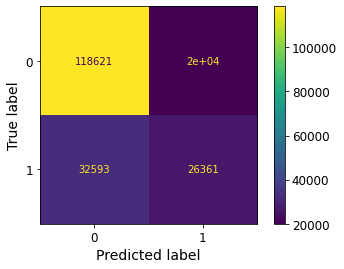

In [81]:
disp_clf_paternal_wic = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_wic)
disp_clf_paternal_wic.plot()
plt.show()

In [44]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not vaginal delivery was attempted prior to cesarean 
cm_clf_paternal_trial = confusion_matrix(y_clf_test.iloc[:,1], y_pred_rf_clf_paternal_optimal[:,1])
cm_clf_paternal_trial

array([[    14,  45189],
       [    40, 152283]])

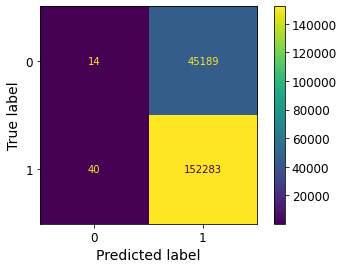

In [82]:
disp_clf_paternal_trial = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_trial)
disp_clf_paternal_trial.plot()
plt.show()

In [45]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not delivery was vaginal
cm_clf_paternal_delivery = confusion_matrix(y_clf_test.iloc[:,2], y_pred_rf_clf_paternal_optimal[:,2])
cm_clf_paternal_delivery

array([[   162,  62701],
       [   208, 134455]])

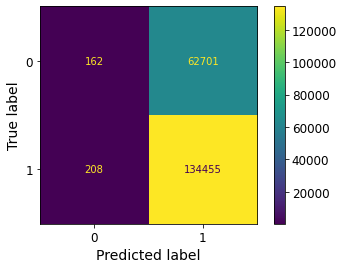

In [83]:
disp_clf_paternal_delivery = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_delivery)
disp_clf_paternal_delivery.plot()
plt.show()

In [46]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not the infant was breastfed at discharge
cm_clf_paternal_bfed = confusion_matrix(y_clf_test.iloc[:,3], y_pred_rf_clf_paternal_optimal[:,3])
cm_clf_paternal_bfed

array([[     4,  33431],
       [    13, 164078]])

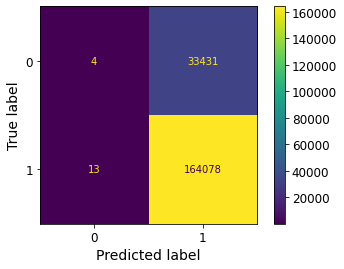

In [84]:
disp_clf_paternal_bfed = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_bfed)
disp_clf_paternal_bfed.plot()
plt.show()

### Maternal Classification Model

In [47]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not a woman received WIC benefits during pregnancy
cm_clf_maternal_wic = confusion_matrix(y_clf_test.iloc[:,0], y_pred_rf_clf_maternal_optimal[:,0])
cm_clf_maternal_wic

array([[120499,  18073],
       [ 33969,  24985]])

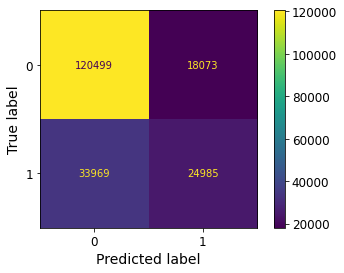

In [85]:
disp_clf_maternal_wic = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_wic)
disp_clf_maternal_wic.plot()
plt.show()

In [48]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not vaginal delivery was attempted prior to cesarean 
cm_clf_maternal_trial = confusion_matrix(y_clf_test.iloc[:,1], y_pred_rf_clf_maternal_optimal[:,1])
cm_clf_maternal_trial

array([[    14,  45189],
       [     7, 152316]])

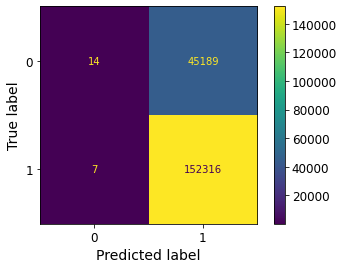

In [86]:
disp_clf_maternal_trial = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_trial)
disp_clf_maternal_trial.plot()
plt.show()

In [49]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not delivery was vaginal
cm_clf_maternal_delivery = confusion_matrix(y_clf_test.iloc[:,2], y_pred_rf_clf_maternal_optimal[:,2])
cm_clf_maternal_delivery

array([[   239,  62624],
       [   189, 134474]])

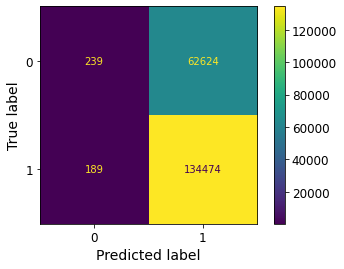

In [87]:
disp_clf_maternal_delivery = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_delivery)
disp_clf_maternal_delivery.plot()
plt.show()

In [50]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not the infant was breastfed at discharge
cm_clf_maternal_bfed = confusion_matrix(y_clf_test.iloc[:,3], y_pred_rf_clf_maternal_optimal[:,3])
cm_clf_maternal_bfed

array([[     0,  33435],
       [     0, 164091]])

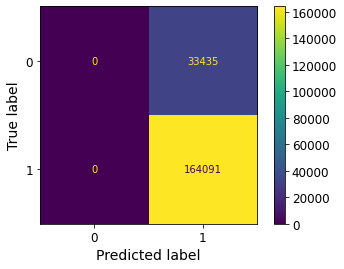

In [88]:
disp_clf_maternal_bfed = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_bfed)
disp_clf_maternal_bfed.plot()
plt.show()

### Combined Paternal and Maternal Classificiation Model

In [54]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not a woman received WIC benefits during pregnancy
cm_clf_combined_wic = confusion_matrix(y_clf_test.iloc[:,0], y_pred_rf_clf_combined_optimal[:,0])
cm_clf_combined_wic

array([[119125,  19447],
       [ 31056,  27898]])

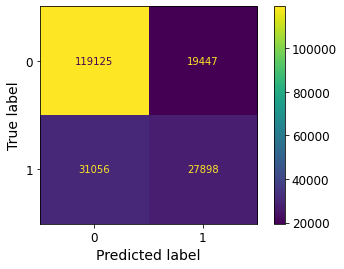

In [89]:
disp_clf_combined_wic = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_wic)
disp_clf_combined_wic.plot()
plt.show()

In [55]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not vaginal delivery was attempted prior to cesarean 
cm_clf_combined_trial = confusion_matrix(y_clf_test.iloc[:,1], y_pred_rf_clf_combined_optimal[:,1])
cm_clf_combined_trial

array([[    55,  45148],
       [    45, 152278]])

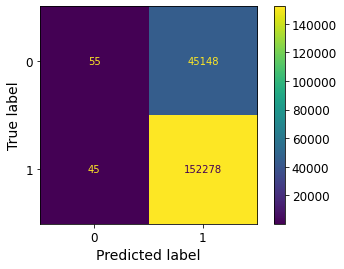

In [90]:
disp_clf_combined_trial = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_trial)
disp_clf_combined_trial.plot()
plt.show()

In [56]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not delivery was vaginal
cm_clf_combined_delivery = confusion_matrix(y_clf_test.iloc[:,2], y_pred_rf_clf_combined_optimal[:,2])
cm_clf_combined_delivery

array([[   512,  62351],
       [   404, 134259]])

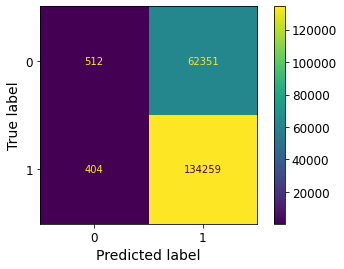

In [91]:
disp_clf_combined_delivery = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_delivery)
disp_clf_combined_delivery.plot()
plt.show()

In [57]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not the infant was breastfed at discharge
cm_clf_combined_bfed = confusion_matrix(y_clf_test.iloc[:,3], y_pred_rf_clf_combined_optimal[:,3])
cm_clf_combined_bfed

array([[     9,  33426],
       [     9, 164082]])

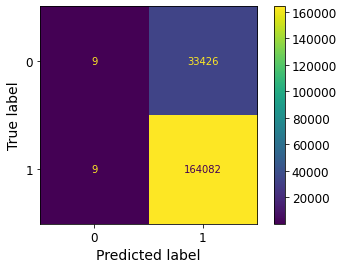

In [92]:
disp_clf_combined_bfed = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_bfed)
disp_clf_combined_bfed.plot()
plt.show()

## Classification Reports for RandomForestClassifier() Models

### Paternal Classification Model

In [40]:
cr_clf_paternal_wic = classification_report(y_clf_test.iloc[:,0],y_pred_rf_clf_paternal_optimal[:,0])
cr_clf_paternal_wic

'              precision    recall  f1-score   support\n\n         0.0       0.78      0.86      0.82    138572\n         1.0       0.57      0.45      0.50     58954\n\n    accuracy                           0.73    197526\n   macro avg       0.68      0.65      0.66    197526\nweighted avg       0.72      0.73      0.72    197526\n'

In [58]:
cr_clf_paternal_trial = classification_report(y_clf_test.iloc[:,1],y_pred_rf_clf_paternal_optimal[:,1])
cr_clf_paternal_trial

'              precision    recall  f1-score   support\n\n         0.0       0.26      0.00      0.00     45203\n         1.0       0.77      1.00      0.87    152323\n\n    accuracy                           0.77    197526\n   macro avg       0.52      0.50      0.44    197526\nweighted avg       0.65      0.77      0.67    197526\n'

In [59]:
cr_clf_paternal_delivery = classification_report(y_clf_test.iloc[:,2],y_pred_rf_clf_paternal_optimal[:,2])
cr_clf_paternal_delivery

'              precision    recall  f1-score   support\n\n         0.0       0.44      0.00      0.01     62863\n         1.0       0.68      1.00      0.81    134663\n\n    accuracy                           0.68    197526\n   macro avg       0.56      0.50      0.41    197526\nweighted avg       0.60      0.68      0.55    197526\n'

In [ ]:
cr_clf_paternal_bfed = classification_report(y_clf_test.iloc[:,3],y_pred_rf_clf_paternal_optimal[:,3])
cr_clf_paternal_bfed

### Maternal Classification Model 

In [60]:
cr_clf_maternal_wic = classification_report(y_clf_test.iloc[:,0],y_pred_rf_clf_maternal_optimal[:,0])
cr_clf_maternal_wic

'              precision    recall  f1-score   support\n\n         0.0       0.78      0.87      0.82    138572\n         1.0       0.58      0.42      0.49     58954\n\n    accuracy                           0.74    197526\n   macro avg       0.68      0.65      0.66    197526\nweighted avg       0.72      0.74      0.72    197526\n'

In [61]:
cr_clf_maternal_trial = classification_report(y_clf_test.iloc[:,1],y_pred_rf_clf_maternal_optimal[:,1])
cr_clf_maternal_trial

'              precision    recall  f1-score   support\n\n         0.0       0.67      0.00      0.00     45203\n         1.0       0.77      1.00      0.87    152323\n\n    accuracy                           0.77    197526\n   macro avg       0.72      0.50      0.44    197526\nweighted avg       0.75      0.77      0.67    197526\n'

In [62]:
cr_clf_maternal_delivery = classification_report(y_clf_test.iloc[:,2],y_pred_rf_clf_maternal_optimal[:,2])
cr_clf_maternal_delivery

'              precision    recall  f1-score   support\n\n         0.0       0.56      0.00      0.01     62863\n         1.0       0.68      1.00      0.81    134663\n\n    accuracy                           0.68    197526\n   macro avg       0.62      0.50      0.41    197526\nweighted avg       0.64      0.68      0.56    197526\n'

In [64]:
cr_clf_maternal_bfed = classification_report(y_clf_test.iloc[:,3],y_pred_rf_clf_maternal_optimal[:,3])
cr_clf_maternal_bfed

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00     33435\n         1.0       0.83      1.00      0.91    164091\n\n    accuracy                           0.83    197526\n   macro avg       0.42      0.50      0.45    197526\nweighted avg       0.69      0.83      0.75    197526\n'

### Combined Paternal and Maternal Classification Model

In [65]:
cr_clf_combined_wic = classification_report(y_clf_test.iloc[:,0],y_pred_rf_clf_combined_optimal[:,0])
cr_clf_combined_wic

'              precision    recall  f1-score   support\n\n         0.0       0.79      0.86      0.83    138572\n         1.0       0.59      0.47      0.52     58954\n\n    accuracy                           0.74    197526\n   macro avg       0.69      0.67      0.67    197526\nweighted avg       0.73      0.74      0.74    197526\n'

In [66]:
cr_clf_combined_trial = classification_report(y_clf_test.iloc[:,1],y_pred_rf_clf_combined_optimal[:,1])
cr_clf_combined_trial

'              precision    recall  f1-score   support\n\n         0.0       0.55      0.00      0.00     45203\n         1.0       0.77      1.00      0.87    152323\n\n    accuracy                           0.77    197526\n   macro avg       0.66      0.50      0.44    197526\nweighted avg       0.72      0.77      0.67    197526\n'

In [67]:
cr_clf_combined_delivery = classification_report(y_clf_test.iloc[:,2],y_pred_rf_clf_combined_optimal[:,2])
cr_clf_combined_delivery

'              precision    recall  f1-score   support\n\n         0.0       0.56      0.01      0.02     62863\n         1.0       0.68      1.00      0.81    134663\n\n    accuracy                           0.68    197526\n   macro avg       0.62      0.50      0.41    197526\nweighted avg       0.64      0.68      0.56    197526\n'

In [68]:
cr_clf_combined_bfed = classification_report(y_clf_test.iloc[:,3],y_pred_rf_clf_combined_optimal[:,3])
cr_clf_combined_bfed

'              precision    recall  f1-score   support\n\n         0.0       0.50      0.00      0.00     33435\n         1.0       0.83      1.00      0.91    164091\n\n    accuracy                           0.83    197526\n   macro avg       0.67      0.50      0.45    197526\nweighted avg       0.77      0.83      0.75    197526\n'

## Permutation Importance for RandomForestClassifier() Models

In [93]:
# permutation importance for paternal RandomForestClassifier Model
r_clf_paternal = permutation_importance(optimal_rf_clf_paternal, X_paternal_test, y_clf_test, n_repeats=5, random_state=42)

In [95]:
joblib.dump(r_clf_paternal, 'pi_clf_paternal.pkl')

['pi_clf_paternal.pkl']

In [ ]:
joblib.load('pi_clf_paternal.pkl')

In [96]:
sorted_importances_idx_clf_paternal = r_clf_paternal.importances_mean.argsort()

In [97]:
importances_clf_paternal = pd.DataFrame(r_clf_paternal.importances[sorted_importances_idx_clf_paternal].T, columns=X_paternal_test.columns[sorted_importances_idx_clf_paternal])

Text(0.5, 1.0, 'Permutation Importances for Features of the Paternal Classification Model')

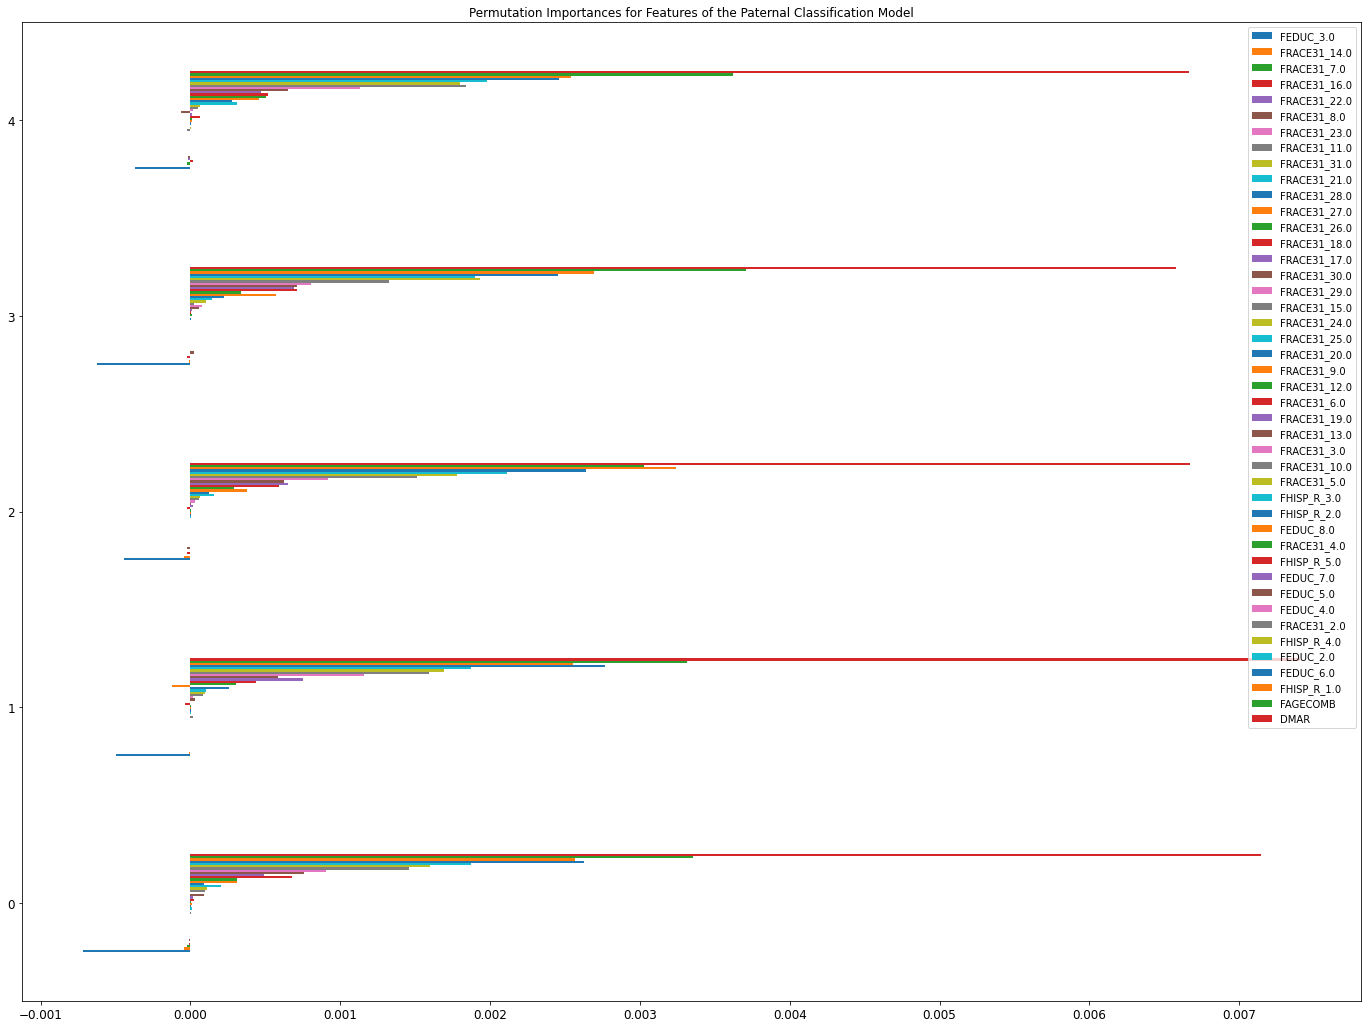

In [115]:
ax = importances_clf_paternal.plot.barh(figsize=(24, 18))
ax.set_title('Permutation Importances for Features of the Paternal Classification Model')


In [ ]:
r_clf_paternal.importances_mean

array([ 6.96617154e-03,  3.29931250e-03,  1.52030619e-03, -8.10019947e-06,
        4.50067333e-04,  6.93579579e-05,  2.83506981e-05, -4.40448346e-05,
       -7.08767453e-06,  7.08767453e-06,  2.88569606e-05, -1.01252493e-06,
        1.51878740e-06,  1.16440367e-05, -1.11377743e-05,  3.03757480e-06,
       -5.06262467e-07,  5.06262467e-07,  0.00000000e+00,  1.21502992e-05,
        0.00000000e+00,  5.06262467e-07, -3.03757480e-06, -5.06262467e-07,
        0.00000000e+00,  6.07514960e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.02504987e-06,  0.00000000e+00,
        2.99606128e-03,  2.55662546e-04,  1.42259753e-04,  1.73141764e-03,
        6.86491905e-04,  1.86912103e-03, -4.96643480e-04,  9.55823537e-04,
        7.01173516e-04,  2.70445410e-03,  8.10019947e-04,  2.97682330e-04])

In [ ]:
r_clf_paternal.importances

array([[ 7.03198566e-03,  7.43193301e-03,  6.74847868e-03,
         6.58141207e-03,  6.64216356e-03,  6.97123417e-03,
         7.50280976e-03,  6.99148467e-03,  6.88516955e-03,
         6.87504430e-03],
       [ 3.32108178e-03,  3.12363942e-03,  2.93632231e-03,
         3.50333627e-03,  3.42739690e-03,  3.72102913e-03,
         3.12363942e-03,  3.15401517e-03,  3.34133228e-03,
         3.34133228e-03],
       [ 1.27578142e-03,  1.63016514e-03,  1.65547827e-03,
         1.20490467e-03,  1.74660551e-03,  1.72635501e-03,
         1.33147029e-03,  1.56941365e-03,  1.49853690e-03,
         1.56435102e-03],
       [-2.53131233e-05, -1.01252493e-05,  1.51878740e-05,
         3.54383727e-05, -1.01252493e-05, -3.03757480e-05,
        -2.53131233e-05, -1.51878740e-05,  1.51878740e-05,
        -3.03757480e-05],
       [ 3.29070603e-04,  4.45510971e-04,  4.70824094e-04,
         3.99947349e-04,  5.82201837e-04,  2.12630236e-04,
         4.40448346e-04,  6.32828083e-04,  4.96137217e-04,
         4.

In [ ]:
# permutation importance for maternal RandomForestClassifier Model
r_clf_maternal = permutation_importance(optimal_rf_clf_maternal, X_maternal_test, y_clf_test, n_repeats=10, random_state=42)

In [ ]:
r_clf_maternal.importances_mean

array([ 6.20323400e-03,  4.50472343e-03,  2.58649494e-03,  6.66241406e-04,
        4.99681055e-04,  2.39462147e-04,  2.73229853e-03,  1.25350587e-03,
        2.42499722e-04,  1.26768122e-03, -4.55636220e-06,  1.33147029e-04,
        4.35385721e-05,  3.89822099e-05,  1.56941365e-05, -8.10019947e-06,
       -4.55636220e-06,  1.31628241e-05,  2.02504987e-06,  0.00000000e+00,
        4.10072598e-05, -1.01252493e-05, -1.31628241e-05,  5.06262467e-06,
        0.00000000e+00,  0.00000000e+00, -1.01252493e-06,  0.00000000e+00,
       -5.06262467e-06,  0.00000000e+00, -4.55636220e-06,  0.00000000e+00,
        6.07514960e-06, -1.01252493e-06,  0.00000000e+00,  0.00000000e+00,
       -5.06262467e-06, -5.06262467e-07,  0.00000000e+00,  1.96075453e-03,
        1.75166813e-04,  1.02771281e-04,  1.50764963e-03,  6.29284246e-04])

In [ ]:
r_clf_maternal.importances

array([[ 6.25740409e-03,  6.62697569e-03,  6.22196572e-03,
         6.09033747e-03,  5.53851139e-03,  6.43459595e-03,
         6.66747669e-03,  5.97389711e-03,  6.05996173e-03,
         6.16121422e-03],
       [ 4.59180057e-03,  4.08047548e-03,  4.63230157e-03,
         4.49561070e-03,  4.40448346e-03,  4.22729160e-03,
         4.68799044e-03,  4.81455606e-03,  4.57661270e-03,
         4.53611170e-03],
       [ 2.48574871e-03,  2.53131233e-03,  2.64269008e-03,
         2.75913044e-03,  2.62750220e-03,  2.78444357e-03,
         2.65787795e-03,  2.48574871e-03,  2.38449622e-03,
         2.50599921e-03],
       [ 4.40448346e-04,  6.27765459e-04,  5.61951338e-04,
         1.04290068e-03,  4.50573595e-04,  6.17640209e-04,
         6.02452335e-04,  7.34080577e-04,  6.22702834e-04,
         9.61898687e-04],
       [ 5.16387716e-04,  5.01199842e-04,  6.02452335e-04,
         4.15135223e-04,  5.01199842e-04,  4.70824094e-04,
         4.35385721e-04,  6.42953333e-04,  4.20197847e-04,
         4.

In [ ]:
# permutation importance for combined RandomForestClassifier Model
r_clf_combined = permutation_importance(optimal_rf_clf_combined, X_combined_test, y_clf_test, n_repeats=10, random_state=42, n_jobs=-1)

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
sorted_clf_combined_importances_idx = r_clf_combined.importances_mean.argsort()

In [ ]:
clf_combined_importances = pd.DataFrame(r_clf_combined.importances[sorted_clf_combined_importances_idx].T, columns=X_combined_train.columns[sorted_clf_combined_importances_idx])

In [ ]:
ax3 = clf_combined_importances.plot.barh()
ax3.set_title('Permutation Importances for Combined Model Features')
ax3.figure.tight_layout()

In [ ]:
r_clf_combined.importances_mean

In [ ]:
r_clf_combined.importances

### Accuracy, Precision, Recall, and F1 Scores for RandomForestClassifier() Models

Accuracy

In [ ]:
#RandomForestClassifier accuracy of default paternal model
rf_paternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_paternal)
rf_paternal_accuracy

0.4312141186476717

In [19]:
#RandomForestClassifier accuracy of optimal paternal model
optimal_rf_paternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_paternal_optimal)
optimal_rf_paternal_accuracy

0.4318874477284003

In [ ]:
#RandomForestClassifier accuracy of default maternal model
rf_maternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_maternal)
rf_maternal_accuracy

0.43215576683575835

In [22]:
#RandomForestClassifier accuracy of optimal maternal model
optimal_rf_maternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_maternal_optimal)
optimal_rf_maternal_accuracy

0.43372518048256936

In [ ]:
#RandomForestClassifier accuracy of default combined model
rf_combined_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_combined)
rf_combined_accuracy

0.4365754381701649

In [ ]:
#RandomForestClassifier accuracy of optimal combined model
optimal_rf_combined_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_combined_optimal)
optimal_rf_combined_accuracy

0.4373652076182376

Precision

In [ ]:
#RandomForestClassifier precision of default paternal model
rf_paternal_precision = precision_score(y_clf_test, y_pred_rf_clf_paternal, average='micro')
rf_paternal_precision

0.7469327383567577

In [ ]:
#RandomForestClassifier precision of optimal paternal model
optimal_rf_paternal_precision = precision_score(y_clf_test, y_pred_rf_clf_paternal_optimal, average='micro')
optimal_rf_paternal_precision

0.747431627560148

In [ ]:
#RandomForestClassifier precision of default maternal model
rf_maternal_precision = precision_score(y_clf_test, y_pred_rf_clf_maternal, average='micro')
rf_maternal_precision

0.7489995487158844

In [ ]:
#RandomForestClassifier precision of optimal maternal model
optimal_rf_maternal_precision = precision_score(y_clf_test, y_pred_rf_clf_maternal_optimal, average='micro')
optimal_rf_maternal_precision

0.7489924922774789

In [ ]:
#RandomForestClassifier precision of default combined model
rf_combined_precision = precision_score(y_clf_test, y_pred_rf_clf_combined, average='micro')
rf_combined_precision

0.7489207271976747

In [ ]:
#RandomForestClassifier precision of optimal combined model
optimal_rf_combined_precision = precision_score(y_clf_test, y_pred_rf_clf_combined_optimal, average='micro')
optimal_rf_combined_precision

0.748821655253571

Recall

In [ ]:
#RandomForestClassifier recall of default paternal model
rf_paternal_recall = recall_score(y_clf_test, y_pred_rf_clf_paternal, average='micro')
rf_paternal_recall

0.9366509094545233

In [ ]:
#RandomForestClassifier recall of optimal paternal model
optimal_rf_paternal_recall = recall_score(y_clf_test, y_pred_rf_clf_paternal_optimal, average='micro')
optimal_rf_paternal_recall

0.9354666677123548

In [ ]:
#RandomForestClassifier recall of default maternal model
rf_maternal_recall = recall_score(y_clf_test, y_pred_rf_clf_maternal, average='micro')
rf_maternal_recall

0.9339353882411069

In [ ]:
#RandomForestClassifier recall of optimal maternal model
optimal_rf_maternal_recall = recall_score(y_clf_test, y_pred_rf_clf_maternal_optimal, average='micro')
optimal_rf_maternal_recall

0.93321582413618

In [ ]:
#RandomForestClassifier recall of default combined model
rf_combined_recall = recall_score(y_clf_test, y_pred_rf_clf_combined, average='micro')
rf_combined_recall

0.9391056622048464

In [ ]:
#RandomForestClassifier recall of optimal combined model
optimal_rf_combined_recall = recall_score(y_clf_test, y_pred_rf_clf_combined_optimal, average='micro')
optimal_rf_combined_recall

0.9382194415633559

F1 Scores

In [ ]:
#RandomForestClassifier F1 scores of default paternal model
rf_paternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_paternal, average='micro')
rf_paternal_f1

0.8311024279580517

In [ ]:
#RandomForestClassifier F1 scores of optimal paternal model
optimal_rf_paternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_paternal_optimal, average='micro')
optimal_rf_paternal_f1

0.8309443011983041

In [ ]:
#RandomForestClassifier F1 scores of default maternal model
rf_maternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_maternal, average='micro')
rf_maternal_f1

0.831306272109627

In [ ]:
#RandomForestClassifier F1 scores of optimal maternal model
optimal_rf_maternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_maternal_optimal, average='micro')
optimal_rf_maternal_f1

0.8310167523635761

In [ ]:
#RandomForestClassifier F1 scores of default combined model
rf_combined_f1 = f1_score(y_clf_test, y_pred_rf_clf_combined, average='micro')
rf_combined_f1

0.8332994079587189

In [ ]:
#RandomForestClassifier F1 scores of optimal combined model
optimal_rf_combined_f1 = f1_score(y_clf_test, y_pred_rf_clf_combined_optimal, average='micro')
optimal_rf_combined_f1

0.8328890583022863

## RandomForestRegressor() Models

In [ ]:
rf_reg_paternal = MultiOutputRegressor(RandomForestRegressor(max_depth=20, random_state=42)).fit(X_paternal_train, y_reg_train)

In [ ]:
#predict responses based on the paternal RandomForestRegressor model
y_pred_rf_reg_paternal = rf_reg_paternal.predict(X_paternal_test)
y_pred_rf_reg_paternal

array([[  11.39048315, 3307.77177097,   38.25474835],
       [  11.45855102, 3288.47827941,   38.27528491],
       [  11.05104166, 3132.30925627,   37.74003829],
       ...,
       [  10.50712116, 3293.6082583 ,   38.12360387],
       [  11.09820264, 3236.99167276,   38.62276032],
       [  10.54311823, 3213.17291354,   38.27903393]])

In [ ]:
rf_reg_maternal = MultiOutputRegressor(RandomForestRegressor(max_depth=20, random_state=42)).fit(X_maternal_train, y_reg_train)

In [ ]:
#predict responses based on the maternal RandomForestRegressor model
y_pred_rf_reg_maternal = rf_reg_maternal.predict(X_maternal_test)
y_pred_rf_reg_maternal

array([[  11.1099296 , 3294.59810081,   38.30883496],
       [  11.48794209, 3267.48933515,   38.03821731],
       [  11.16630066, 3029.67878902,   37.77649994],
       ...,
       [  10.95386638, 3284.23851661,   38.11784988],
       [  11.16602987, 3297.32887096,   38.53938926],
       [  10.4337081 , 3225.99920299,   38.22980417]])

In [ ]:
rf_reg_combined = MultiOutputRegressor(RandomForestRegressor(max_depth=20, random_state=42)).fit(X_combined_train, y_reg_train)

In [ ]:
#predict responses based on the combined RandomForestRegressor model
y_pred_rf_reg_combined = rf_reg_combined.predict(X_combined_test)
y_pred_rf_reg_combined

array([[  11.04423097, 3287.21054361,   38.26774216],
       [  11.17458874, 3265.00916202,   37.95966898],
       [  11.12634603, 3056.56636242,   37.33041177],
       ...,
       [  10.71252286, 3256.777225  ,   37.82706267],
       [  11.11888344, 3213.81876954,   38.48181137],
       [  10.56187618, 3244.77889299,   38.33209164]])

In [ ]:
#generalization error default paternal RandomForestRegressor model
rf_reg_paternal_y_pred = rf_reg_paternal.predict(X_paternal_test)
mse_rf_reg_paternal = mean_squared_error(y_reg_test, rf_reg_paternal_y_pred)
mse_rf_reg_paternal

102731.99931139528

In [ ]:
#generalization error default maternal RandomForestRegressor model
rf_reg_maternal_y_pred = rf_reg_maternal.predict(X_maternal_test)
mse_rf_reg_maternal = mean_squared_error(y_reg_test, rf_reg_maternal_y_pred)
mse_rf_reg_maternal

102429.51807068492

In [ ]:
#generalization error default combined RandomForestRegressor model
rf_reg_combined_y_pred = rf_reg_combined.predict(X_combined_test)
mse_rf_reg_combined = mean_squared_error(y_reg_test, rf_reg_combined_y_pred)
mse_rf_reg_combined

102165.19081679532

### Hyperparameter Tuning for RandomForestRegressor() Models

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=6, min_samples_split=2, random_state=42)
reg_model = MultiOutputClassifier(estimator=rf_reg)

#### Paternal Features Model

In [ ]:
# Coarse RandomForestRegressor GridSearch - paternal
param_grid_coarse_reg_paternal = {'estimator__max_depth':[2, 4, 5, 8],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 7, 9]}

gscv_paternal_reg_coarse = GridSearchCV(reg_model, param_grid_coarse_reg_paternal, n_jobs=-1, cv=3)
gscv_paternal_reg_coarse.fit(X_paternal_train, y_clf_train)

print("The best coarse parameters are: ", gscv_paternal_reg_coarse.best_params_)

In [ ]:
# Refined RandomForestRegressor GridSearch - paternal
param_grid_refined_reg_paternal = {'estimator__max_depth':[2, 4, 5, 8],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 7, 9]}

gscv_paternal_reg_refined = GridSearchCV(reg_model, param_grid_refined_reg_paternal, n_jobs=-1, cv=3)
gscv_paternal_reg_refined.fit(X_paternal_train, y_clf_train)

print("The best coarse parameters are: ", gscv_paternal_reg_refined.best_params_)

In [ ]:
# Final RandomForestRegressor GridSearch - paternal
param_grid_final_reg_paternal = {'estimator__max_depth':[2, 4, 5, 8],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 7, 9]}

gscv_paternal_reg_final = GridSearchCV(reg_model, param_grid_final_reg_paternal, n_jobs=-1, cv=3)
gscv_paternal_reg_final.fit(X_paternal_train, y_clf_train)

print("The best coarse parameters are: ", gscv_paternal_reg_final.best_params_)

In [ ]:
# Optimal RandomForestRegressor Model based on GridSearch results for paternal features
# optimal_rf_reg_paternal = RandomForestRegressor(max_depth=grid_search_cv_final_rf_reg_paternal.best_params_['max_depth'],
#                                    n_estimators=grid_search_cv_final_rf_reg_paternal.best_params_['n_estimators'],
#                                    min_samples_split=grid_search_cv_final_rf_reg_paternal.best_params_['min_samples_split'],
#                                    random_state=42)
# optimal_rf_reg_paternal.fit(X_paternal_train, y_reg_train)

#### Maternal Features Model

In [ ]:
# Coarse RandomForestRegressor GridSearch - maternal
param_grid_coarse_reg_maternal = {'estimator__max_depth':[2, 4, 5, 8],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 7, 9]}

gscv_maternal_reg_coarse = GridSearchCV(reg_model, param_grid_coarse_reg_maternal, n_jobs=-1, cv=3)
gscv_maternal_reg_coarse.fit(X_maternal_train, y_clf_train)

print("The best coarse parameters are: ", gscv_maternal_reg_coarse.best_params_)

In [ ]:
# Coarse RandomForestRegressor GridSearch - maternal
# param_grid_coarse_maternal = {'estimator__max_depth':[2, 4, 5, 8],
#               'estimator__n_estimators':[250, 500, 750, 1000],
#               'estimator__min_samples_split':[3, 5, 7, 9]}

# gscv_maternal_reg_coarse = GridSearchCV(reg_model, param_grid_coarse_maternal, n_jobs=-1, cv=3)
# gscv_maternal_reg_coarse.fit(X_maternal_train, y_clf_train)

# print("The best coarse parameters are: ", gscv_maternal_reg_coarse.best_params_)

In [ ]:
# Refined RandomForestRegressor GridSearch - maternal

param_grid_refined_rf_reg_maternal = {'max_depth':[4,5,6,7,8], 
              'n_estimators': [900, 950, 1000, 1050, 1100], 
              'min_samples_split': [5,6,7,8,9,10,11,12]}

grid_search_cv_refined_rf_reg_maternal = GridSearchCV(RandomForestRegressor(random_state=42), 
                                                      param_grid_refined_rf_reg_maternal, verbose=1, cv=3)
grid_search_cv_refined_rf_reg_maternal.fit(X_maternal_train, y_reg_train)

print("The best parameters are: ", grid_search_cv_refined_rf_reg_maternal.best_params_)

In [ ]:
# Final RandomForestRegressor GridSearch - maternal

param_grid_final_rf_reg_maternal = {'max_depth':[5], 
              'n_estimators': [750, 800, 850, 900, 950, 1000], 
              'min_samples_split': [8]}

grid_search_cv_final_rf_reg_maternal = GridSearchCV(RandomForestRegressor(random_state=42), 
                                                    param_grid_final_rf_reg_maternal, verbose=1, cv=3)
grid_search_cv_final_rf_reg_maternal.fit(X_maternal_train, y_reg_train)

print("The best parameters are: ", grid_search_cv_final_rf_reg_maternal.best_params_)

In [ ]:
# Optimal RandomForestRegressor Model based on GridSearch results for maternal features
optimal_rf_reg_maternal = RandomForestRegressor(max_depth=grid_search_cv_final_rf_reg_maternal.best_params_['max_depth'],
                                   n_estimators=grid_search_cv_final_rf_reg_maternal.best_params_['n_estimators'],
                                   min_samples_split=grid_search_cv_final_rf_reg_maternal.best_params_['min_samples_split'],
                                   random_state=42)
optimal_rf_reg_maternal.fit(X_maternal_train, y_reg_train)

#### Combined Paternal and Maternal Features Model

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
# Coarse Grained Regressor with Optuna
def objective(trial):
  data = final_data.iloc[:1000]
  n_estimators = trial.suggest_int('estimator__n_estimators', 100, 1000)
  max_depth = int(trial.suggest_loguniform('estimator__max_depth', 1, 32))
  reg = reg_model
  return cross_val_score(reg, X_combined_train, y_reg_train, n_jobs=-1, cv=3)

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print('Best hyperparameters: {}'.format(trial.params))

[I 2023-02-10 15:06:49,911] A new study created in memory with name: no-name-6fa390a0-aa6a-4bb3-b9bf-437315bf8841
<ipython-input-17-003b1e9dba99>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_depth = int(trial.suggest_loguniform('estimator__max_depth', 1, 32))
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-package

KeyboardInterrupt: ignored

In [ ]:
# Coarse-Grained RandomForestRegressor GridSearch - combined

param_grid_coarse_rf_reg_combined = {'max_depth':[1,2,4,5,8,20], 
              'n_estimators': [250, 500, 1000], 
              'min_samples_split': [2,4,5,8,12,20]}

grid_search_cv_coarse_rf_reg_combined = GridSearchCV(RandomForestRegressor(random_state=42), 
                                                     param_grid_coarse_rf_reg_combined, verbose=1, cv=3)
grid_search_cv_coarse_rf_reg_combined.fit(X_combined_train, y_reg_train)

print("The best parameters are: ", grid_search_cv_coarse_rf_reg_combined.best_params_)

In [ ]:
# Refined RandomForestRegressor GridSearch - combined

param_grid_refined_rf_reg_combined = {'max_depth':[4,5,6,7,8], 
              'n_estimators': [900, 950, 1000, 1050, 1100], 
              'min_samples_split': [5,6,7,8,9,10,11,12]}

grid_search_cv_refined_rf_reg_combined = GridSearchCV(RandomForestRegressor(random_state=42), 
                                                      param_grid_refined_rf_reg_combined, verbose=1, cv=3)
grid_search_cv_refined_rf_reg_combined.fit(X_combined_train, y_reg_train)

print("The best parameters are: ", grid_search_cv_refined_rf_reg_combined.best_params_)

In [ ]:
# Final RandomForestRegressor GridSearch - combined

param_grid_final_rf_reg_combined = {'max_depth':[5], 
              'n_estimators': [750, 800, 850, 900, 950, 1000], 
              'min_samples_split': [8]}

grid_search_cv_final_rf_reg_combined = GridSearchCV(RandomForestRegressor(random_state=42), 
                                                    param_grid_final_rf_reg_combined, verbose=1, cv=3)
grid_search_cv_final_rf_reg_combined.fit(X_combined_train, y_reg_train)

print("The best parameters are: ", grid_search_cv_final_rf_reg_combined.best_params_)

In [ ]:
# Optimal RandomForestRegressor Model based on GridSearch results for combined paternal and maternal features
optimal_rf_reg_combined = RandomForestRegressor(max_depth=grid_search_cv_final_rf_reg_combined.best_params_['max_depth'],
                                   n_estimators=grid_search_cv_final_rf_reg_combined.best_params_['n_estimators'],
                                   min_samples_split=grid_search_cv_final_rf_reg_combined.best_params_['min_samples_split'],
                                   random_state=42)
optimal_rf_reg_combined.fit(X_combined_train, y_reg_train)

### Permutation Importance for RandomForestRegressor() Models

In [ ]:
# permutation importance for paternal RandomForestRegressor Model
r_reg_paternal = permutation_importance(rf_reg_paternal, X_paternal_test, y_reg_test, n_repeats=10, random_state=42)

In [ ]:
r_reg_paternal.importances_mean

In [ ]:
r_reg_paternal.importances_mean

In [ ]:
# permutation importance for maternal RandomForestRegressor Model
r_reg_maternal = permutation_importance(rf_reg_maternal, X_maternal_test, y_reg_test, n_repeats=10, random_state=42)

In [ ]:
r_reg_maternal.importances_mean

In [ ]:
r_reg_maternal.importances

In [ ]:
# permutation importance for combined RandomForestRegressor Model
r_reg_combined = permutation_importance(rf_reg_combined, X_combined_test, y_reg_test, n_repeats=10, random_state=42)

In [ ]:
r_reg_combined.importances_mean

In [ ]:
r_reg_combined.importances

## Visual Comparison of MultiOutputRegressor Models

In [ ]:
# Plot the results
plt.figure()
s = 50
a = 0.4
# Data
plt.scatter(
    y_reg_test[:, 0],
    y_reg_test[:, 1],
    y_reg_test[:, 2],
    edgecolor="k",
    c="navy",
    s=s,
    marker="s",
    alpha=a,
    label="Data",
)
# Paternal features
plt.scatter(
    y_pred_rf_reg_paternal[:, 0],
    y_pred_rf_reg_paternal[:, 1],
    y_pred_rf_reg_paternal[:, 2],
    edgecolor="k",
    c="cornflowerblue",
    s=s,
    marker='o'
    alpha=a,
    label="MultiOutputRegressor RF Paternal score=%.2f" % rf_reg_paternal.score(X_paternal_test, y_reg_test),
)
# Maternal features
plt.scatter(
    y_pred_rf_reg_maternal[:, 0],
    y_pred_rf_reg_maternal[:, 1],
    y_pred_rf_reg_maternal[:, 2],
    edgecolor="k",
    c="lightsteelblue",
    s=s,
    marker='^'
    alpha=a,
    label="MultiOutputRegressor RF Maternal score=%.2f" % rf_reg_maternal.score(X_maternal_test, y_reg_test),
)
# Combined Paternal and Maternal features
plt.scatter(
    y_pred_rf_reg_combined[:, 0],
    y_pred_rf_reg_combined[:, 1],
    y_pred_rf_reg_combined[:, 2],
    edgecolor="k",
    c="mediumpurple",
    s=s,
    marker='*'
    alpha=a,
    label="MultiOutputRegressor RF Combined Paternal & Maternal score=%.2f" % rf_reg_combined.score(X_combined_test, y_reg_test),
)

plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.zlim([-6, 6])
plt.xlabel("Prenatal Visits")
plt.ylabel("Birth Weight")
plt.zlabel('Gestational Age')
plt.title("Comparing MultiOutputRegressor Models with Paternal, Maternal, and Combined Features")
plt.legend()
plt.show()

### Generalization Error for RandomForestRegressor() Models

In [ ]:
from sklearn.metrics import mean_squared_error

#https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py
# rf_reg_paternal.score()

#generalization error paternal RandomForestRegressor model
optimal_rf_reg_paternal_y_pred = optimal_rf_reg_paternal.predict(X_paternal_test)
optimal_mse_rf_reg_paternal = mean_squared_error(y_reg_test, optimal_rf_reg_paternal_y_pred)

#generalization error maternal RandomForestRegressor model
optimal_rf_reg_maternal_y_pred = optimal_rf_reg_maternal.predict(X_maternal_test)
optimal_mse_rf_reg_maternal = mean_squared_error(y_reg_test, optimal_rf_reg_maternal_y_pred)

#generalization error combined RandomForestRegressor model
optimal_rf_reg_combined_y_pred = optimal_rf_reg_combined.predict(X_combined_test)
optimal_mse_rf_reg_combined = mean_squared_error(y_reg_test, optimal_rf_reg_combined_y_pred)


print("Generalization error for Optimal Paternal Random Forest Regressor Model: ", round(optimal_mse_rf_reg_paternal, 4))
print("Generalization error for Optimal Maternal Random Forest Regressor Model: ", round(optimal_mse_rf_reg_maternal, 4))
print("Generalization error for Optimal Combined Random Forest Regressor Model: ", round(optimal_mse_rf_reg_combined, 4))

## References

Mutsaerts, M. A. Q., Groen, H., Buiter-Van der Meer, A., Sijtsma, A., Sauer, P. J. J., Land, J. A., Mol, B. W., Corpeleijn, E., & Hoek, A.  (2014).  Effects of paternal and maternal lifestyle factors on pregnancy complications and perinatal outcome.  A population-based birth-cohort study: the GECKO Drenthe cohort.  Human Reproduction, 29(4), 824-834.  https://doi.org/10.1093/humrep/deu006 
